In [1]:
import pandas as pd
import numpy as np
import missingno as msn
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer

In [2]:
df_test = pd.read_csv('test.csv')
df_test['Set'] = 'Test'
df_train = pd.read_csv('train.csv')
df_train['Set'] = 'Train'

df = pd.concat([df_train, df_test])
df.isnull().sum()

id                   0
brand                0
model                0
model_year           0
milage               0
fuel_type         8466
engine               0
transmission         0
ext_col              0
int_col              0
accident          4084
clean_title      35658
price           125690
Set                  0
dtype: int64

In [3]:
df.head(10)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Set
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200.0,Train
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999.0,Train
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900.0,Train
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000.0,Train
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500.0,Train
5,5,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950.0,Train
6,6,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500.0,Train
7,7,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500.0,Train
8,8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890.0,Train
9,9,BMW,M4 Base,2015,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000.0,Train


Algunos datos del dataset están puestos como '-' indicando que el dato falta, para facilitar trabajar con ellos los vamos a convertir a datos perdidos.

In [4]:
df.replace('–', np.nan, inplace=True)

Convertimos el año de modelo a edad del coche para que sea más fácil de ver

In [5]:
df['Age'] = 2024 - df['model_year']

La variable 'engine' parece que incorpora bastante información relevante, como la potencia, litros, cilindraje e incluso 'fuel_type'. Por tanto vamos a separarla en cuatro columnas.

In [6]:
df[['horsepower', 'liters', 'cylinder', 'fuel_type_engine']] = df['engine'].str.extract(
    r'(?:(?P<HorsePower>\d+\.?\d*)HP)?\s*(?:(?P<Liters>\d+\.?\d*)L)?\s*(?:(?P<Cylinder>\d+)\sCylinder)?(?:.*\s(?P<Fuel_type_engine>\w+)\sFuel)?'
)

df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
df['liters'] = pd.to_numeric(df['liters'], errors='coerce')
df['cylinder'] = pd.to_numeric(df['cylinder'], errors='coerce')

Vamos a intentar rellenar los datos faltantes en fuel_type con los datos de fuel_type_engine extraidos de los datos del motor.

In [7]:
filtro = (df['fuel_type'].isna())

for idx, row in df[filtro].iterrows():
    coincidencias = df[(df['brand'] == row['brand']) & (df['model'] == row['model'])]
    if not coincidencias['fuel_type_engine'].isna().all():
        df.at[idx, 'fuel_type'] = coincidencias['fuel_type_engine'].values[0]

Podemos ver también si podemos rellenar datos faltantes de algun modelo de coche que si esté especificado en otra fila del df

In [8]:
columnas_a_rellenar = ['fuel_type', 'horsepower', 'liters', 'cylinder']

for (brand, model), group in df.groupby(['brand', 'model']):
    # Para cada columna a rellenar
    for columna in columnas_a_rellenar:
        # Obtenemos los valores no faltantes (que no sean 'NaN' o '–')
        valores_no_faltantes = group[columna].dropna()

        # Si hay algún valor no faltante, usamos el primero para reemplazar los faltantes
        if not valores_no_faltantes.empty:
            valor_a_usar = valores_no_faltantes.iloc[0]

            # Reemplazamos los valores faltantes (NaN o '–') con el valor obtenido
            df.loc[(df['brand'] == brand) & (df['model'] == model) & 
                   (df[columna].isna()), columna] = valor_a_usar

In [9]:
df.isnull().sum()

id                       0
brand                    0
model                    0
model_year               0
milage                   0
fuel_type               78
engine                1542
transmission           127
ext_col                589
int_col               7480
accident              4084
clean_title          35658
price               125690
Set                      0
Age                      0
horsepower             749
liters                1880
cylinder             22055
fuel_type_engine     63781
dtype: int64

Parece que hemos conseguido recuperar bastantes datos de 'fuel_type'. Hay algunos datos que parece poco porbable que podamos recuperar como el color del exterior y del interior o datos referidos al motor que no hayamos podido recuperar ya.

Con respecto a los accidentes, teniendo en cuenta que tenemos dos posibilidades 'Más de un accidente' o 'sin accidentes', podemos hacer o una imputación normal o podemos hacer una asunción de que si no hay datos de accidentes, puede ser porque lo haya tenido y no quiera reportarse para no devaluar el precio del coche, por lo que podemos imputar esos datos como 'At least 1 accident'.

In [10]:
df.loc[df['accident'].isna(), 'accident'] = 'At least 1 accident or damage reported'

Si nos fijamos en la variable 'clean_title' vemos que solo toma dos valores, o 'Si' o dato perdido, clean_title hace referencia a que el coche nunca se ha considerado 'siniestro total', lo cual devaluaría mucho su precio de mercado. Como no tenemos ningún dato de coches que no tengan este dato no podemos imputarlo. La única reflexión a la que podemos llegar es que si el coche presenta algún accidente y un dato perdido en esta variable, es posible que se intente ocultar que el coche haya sido 'siniestro total'. El imputar esta variable o no depende de lo valiente que se sienta cada uno, pero parece que lo correcto es no considerarla para el modelo ya que no da información fiable.

In [11]:
columns = df.columns
n_values = [df[a].unique() for a in df.columns]

cuenta = pd.DataFrame()
cuenta['features'] = columns
cuenta['n_values'] = n_values
cuenta.iloc[7, 1]

array(['A/T', 'Transmission w/Dual Shift Mode', '7-Speed A/T',
       '8-Speed A/T', '10-Speed Automatic', '1-Speed A/T', '6-Speed A/T',
       '10-Speed A/T', '9-Speed A/T', '8-Speed Automatic',
       '9-Speed Automatic', '5-Speed A/T', 'Automatic',
       '7-Speed Automatic with Auto-Shift', 'CVT Transmission',
       '5-Speed M/T', 'M/T', '6-Speed M/T', '6-Speed Automatic',
       '4-Speed Automatic', '7-Speed M/T', '2-Speed A/T',
       '1-Speed Automatic', 'Automatic CVT', '4-Speed A/T',
       '6-Speed Manual', 'Transmission Overdrive Switch',
       '8-Speed Automatic with Auto-Shift', '7-Speed Manual',
       '7-Speed Automatic', '9-Speed Automatic with Auto-Shift',
       '6-Speed Automatic with Auto-Shift',
       '6-Speed Electronically Controlled Automatic with O', 'F', 'CVT-F',
       '8-Speed Manual', 'Manual', nan, '2', '6 Speed At/Mt',
       '5-Speed Automatic', '2-Speed Automatic', '8-SPEED A/T', '7-Speed',
       'Variable', 'Single-Speed Fixed Gear', '8-SPEED AT',


In [12]:
df.loc[(df['accident'] == 'At least 1 accident or damage reported') & (df['clean_title'].isna())]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Set,Age,horsepower,liters,cylinder,fuel_type_engine
60,60,Mercedes-Benz,GLS 450 Base 4MATIC,2017,44147,Gasoline,3.0L V6 24V GDI DOHC Twin Turbo,9-Speed Automatic,White,Parchment.,At least 1 accident or damage reported,NaN,29999.0,Train,7,362.0,3.0,8.0,NaN
87,87,RAM,2500 Big Horn,2012,95400,Diesel,350.0HP 6.7L Straight 6 Cylinder Engine Diesel...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,NaN,27899.0,Train,12,350.0,6.7,8.0,Diesel
122,122,Acura,TLX,2020,60854,Gasoline,2.0 Liter DOHC Turbo,Automatic,Platinum White Pearl,Ebony,At least 1 accident or damage reported,NaN,19425.0,Train,4,206.0,2.4,4.0,NaN
134,134,Jeep,Gladiator Sport,2021,61341,Gasoline,3.6L V6 24V MPFI DOHC,8-Speed Automatic,Firecracker Red Clearcoat,Black,At least 1 accident or damage reported,NaN,32455.0,Train,3,285.0,3.6,NaN,NaN
164,164,Acura,RDX w/A-Spec Package,2023,39517,Gasoline,2.0 Liter DOHC Turbo,Automatic,Gray,Black,At least 1 accident or damage reported,NaN,29645.0,Train,1,272.0,2.0,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125424,313957,Audi,S5 3.0T Prestige,2019,67015,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,At least 1 accident or damage reported,NaN,NaN,Test,5,333.0,3.0,4.0,NaN
125425,313958,Chevrolet,Silverado 1500 RST,2021,16184,Gasoline,1.3L I3 12V GDI DOHC Turbo,Automatic,Shadow Gray Metallic,Dark Ash,At least 1 accident or damage reported,NaN,NaN,Test,3,355.0,1.3,8.0,NaN
125492,314025,Dodge,Ram 3500 Quad Cab DRW,2006,110500,Diesel,400.0HP 6.7L Straight 6 Cylinder Engine Diesel...,6-Speed A/T,Red,Gray,At least 1 accident or damage reported,NaN,NaN,Test,18,400.0,6.7,8.0,Diesel
125596,314129,Lexus,LX 570 Three-Row,2021,30630,Gasoline,383.0HP 5.7L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,At least 1 accident or damage reported,NaN,NaN,Test,3,383.0,5.7,8.0,Gasoline


### Feature engenieering


Podemos generar algunas características nuevas para el conjunto de datos a partir de lo que tenemos para poder hacer imputaciones más eficientes y además dar más información al modelo para entrenar.

Para empezar podemos generar una nueva variable que sea el kilometraje por años, para determinar si el coche se ha movido mucho para los años que tiene, lo cual será relevante a la hora de hacer una venta.

Podemos también agrupar los coches en función de si se consideran marcas de lujo o no, ya que por una parte será relevante para predecir precios, y además, nos puede servir para hacer ciertas imputaciones como los colores de exterior e interior, que probablemente sean distribuciones distintas que si consideramos todas las marcas.

También podemos dividir la transmisión entre Automáticos o no automáticos, para reducir la sobrerepresentación de diferentes tipos de transmisiones automáticas.

Después podemos reconfigurar algunas variables para que tengan un formato numérico ajustado a las categorías que representan para luego trabajar con ello en el modelo sin necesidad de generar nuevas columnas con algun método de encoding.

In [13]:
df['milage_per_year'] = df['milage']/df['Age']

luxury_brand = ['Mercedes-Benz', 'BMW', 'Audi', 'Lexus', 'Tesla', 'Aston']

ultra_luxury_brand = ['Porsche', 'McLaren', 'Jaguar', 'Rolls-Royce', 'Maserati', 'Bentley', 'Ferrari', 'Lamborghini', 'Bugatti', 'Maybach']

def assign_luxury(brand):
    if brand in ultra_luxury_brand:
        return 2
    elif brand in luxury_brand:
        return 1
    else:
        return 0

# Aplicamos la función a la columna 'brand'
df['luxury'] = df['brand'].apply(assign_luxury)

In [14]:
transmission_list = cuenta.iloc[7, 1]

df_t = pd.DataFrame(transmission_list, columns=['transmission'])

def assign_transmission_type(transmission):
    if isinstance(transmission, str) and ('automatic' in transmission.lower() or 'a/t' in transmission.lower()):
        return 0  # Transmisión automática
    else:
        return 1  # Resto de transmisiones

df['transmission_type'] = df['transmission'].apply(assign_transmission_type)

In [15]:
df.isnull().sum()

id                        0
brand                     0
model                     0
model_year                0
milage                    0
fuel_type                78
engine                 1542
transmission            127
ext_col                 589
int_col                7480
accident                  0
clean_title           35658
price                125690
Set                       0
Age                       0
horsepower              749
liters                 1880
cylinder              22055
fuel_type_engine      63781
milage_per_year           0
luxury                    0
transmission_type         0
dtype: int64

Vamos a imputar por moda, teniendo en cuenta los grupos que hemos ido creando, el color del interior y exterior del coche. También imputaremos los motores que faltan en función de marca y modelo de coche por moda y las variables numéricas las imputaremos utilizando knn. Habría que plantearse si queremos imputar la cilindrada de los coches ya que presentan bastantes datos perdidos.

In [16]:
def imputar_por_moda(grupo):
    # Imputar 'ext_col' y 'int_col' con la moda del grupo
    grupo['ext_col'] = grupo['ext_col'].fillna(grupo['ext_col'].mode()[0])
    grupo['int_col'] = grupo['int_col'].fillna(grupo['int_col'].mode()[0])
    return grupo

df = df.groupby('luxury').apply(imputar_por_moda)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6340\898025746.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('luxury').apply(imputar_por_moda)


In [17]:
def imputar_por_moda_engine(grupo):
    # Imputar 'engine' con la moda del grupo
    grupo['engine'] = grupo['engine'].fillna(grupo['engine'].mode()[0] if not grupo['engine'].mode().empty else np.nan)
    return grupo

df = df.groupby(['brand', 'model']).apply(imputar_por_moda_engine)

C:\Users\Alberto\AppData\Local\Temp\ipykernel_6340\3808513533.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grupo['engine'] = grupo['engine'].fillna(grupo['engine'].mode()[0] if not grupo['engine'].mode().empty else np.nan)
C:\Users\Alberto\AppData\Local\Temp\ipykernel_6340\3808513533.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['brand', 'model']).apply(imputar_por_moda_engine)


In [18]:
df.isnull().sum()

id                        0
brand                     0
model                     0
model_year                0
milage                    0
fuel_type                78
engine                   37
transmission            127
ext_col                   0
int_col                   0
accident                  0
clean_title           35658
price                125690
Set                       0
Age                       0
horsepower              749
liters                 1880
cylinder              22055
fuel_type_engine      63781
milage_per_year           0
luxury                    0
transmission_type         0
dtype: int64

In [19]:
imputer_knn = KNNImputer(n_neighbors=5)
columnas_num = df.select_dtypes(include=['float64', 'int64']).columns.drop('price', 'id')
columnas_cat = df.select_dtypes(exclude=['float64', 'int64']).columns

df.replace([np.inf, -np.inf], np.nan, inplace=True)

data_imputed = imputer_knn.fit_transform(df[columnas_num])

df_imputed = pd.DataFrame(data_imputed, columns = columnas_num)

df_final = pd.concat([df[columnas_cat].reset_index(drop=True), df_imputed], axis=1)
df_final = pd.concat([df['price'].reset_index(drop=True), df_final], axis=1)

df_final.head()

,price,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,...,id,model_year,milage,Age,horsepower,liters,cylinder,milage_per_year,luxury,transmission_type
0,NaN,Acura,135 is,Gasoline,300.0HP 3.7L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported,Yes,...,269688.0,2013.0,111773.0,11.0,300.0,3.7,4.8,10161.181818,0.0,0.0
1,19500.0,Acura,300 Touring,Gasoline,250.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Gray,Gray,None reported,Yes,...,184011.0,2005.0,98000.0,19.0,250.0,3.5,5.8,5157.894737,0.0,0.0
2,28500.0,Acura,330 i xDrive,Gasoline,320.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,...,45767.0,2018.0,58700.0,6.0,320.0,3.0,7.2,9783.333333,0.0,0.0
3,17000.0,Acura,335 is,Gasoline,320.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,A/T,White,Beige,None reported,Yes,...,91816.0,2012.0,127600.0,12.0,320.0,3.0,5.6,10633.333333,0.0,0.0
4,NaN,Acura,911 Carrera S,Gasoline,443.0HP 3.0L Flat 6 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,White,None reported,Yes,...,197400.0,2023.0,13250.0,1.0,443.0,3.0,7.2,13250.000000,0.0,0.0


In [20]:
df_final.isnull().sum()


price                125690
brand                     0
model                     0
fuel_type                78
engine                   37
transmission            127
ext_col                   0
int_col                   0
accident                  0
clean_title           35658
Set                       0
fuel_type_engine      63781
id                        0
model_year                0
milage                    0
Age                       0
horsepower                0
liters                    0
cylinder                  0
milage_per_year           0
luxury                    0
transmission_type         0
dtype: int64

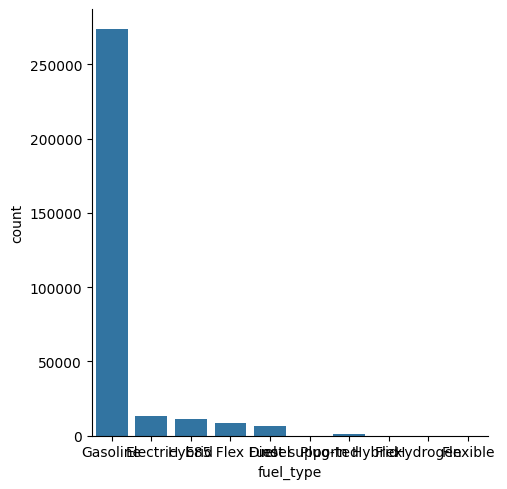

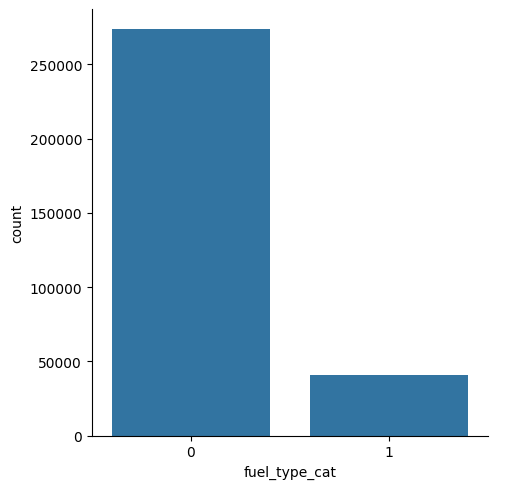

In [21]:
sns.catplot(df_final, x = 'fuel_type', kind = 'count')
df_final['fuel_type_cat'] = np.where(df_final['fuel_type'] == 'Gasoline', 0, 1)
sns.catplot(df_final, x = 'fuel_type_cat', kind = 'count')
df_final['Age_era'] = np.where(df_final['Age'] < 24, 0, 1)
df_final['accident'] = np.where(df_final['accident'] == 'None reported', 0 , 1)

In [22]:
columns = df_final.columns
n_values = [df_final[a].unique() for a in df_final.columns]

cuenta = pd.DataFrame()
cuenta['features'] = columns
cuenta['n_values'] = n_values
cuenta

,features,n_values
0,price,"[nan, 19500.0, 28500.0, 17000.0, 10000.0, 2562..."
1,brand,"[Acura, Alfa, Aston, Audi, BMW, Bentley, Bugat..."
2,model,"[135 is, 300 Touring, 330 i xDrive, 335 is, 91..."
3,fuel_type,"[Gasoline, Electric, Hybrid, E85 Flex Fuel, Di..."
4,engine,[300.0HP 3.7L V6 Cylinder Engine Gasoline Fuel...
5,transmission,"[A/T, 6-Speed A/T, 8-Speed A/T, 9-Speed Automa..."
6,ext_col,"[White, Gray, Black, Blue, Ebony Twilight Meta..."
7,int_col,"[Beige, Gray, Black, White, Ebony, Red, Orchid..."
8,accident,"[0, 1]"
9,clean_title,"[Yes, nan]"


In [23]:
columnas_sobrantes = ['fuel_type_engine', 'model_year', 'clean_title']
df_final = df_final.drop(columnas_sobrantes, axis = 1)
df_final.head()

,price,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,Set,...,milage,Age,horsepower,liters,cylinder,milage_per_year,luxury,transmission_type,fuel_type_cat,Age_era
0,NaN,Acura,135 is,Gasoline,300.0HP 3.7L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,0,Test,...,111773.0,11.0,300.0,3.7,4.8,10161.181818,0.0,0.0,0,0
1,19500.0,Acura,300 Touring,Gasoline,250.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Gray,Gray,0,Train,...,98000.0,19.0,250.0,3.5,5.8,5157.894737,0.0,0.0,0,0
2,28500.0,Acura,330 i xDrive,Gasoline,320.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed A/T,Black,Black,1,Train,...,58700.0,6.0,320.0,3.0,7.2,9783.333333,0.0,0.0,0,0
3,17000.0,Acura,335 is,Gasoline,320.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,A/T,White,Beige,0,Train,...,127600.0,12.0,320.0,3.0,5.6,10633.333333,0.0,0.0,0,0
4,NaN,Acura,911 Carrera S,Gasoline,443.0HP 3.0L Flat 6 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,White,0,Test,...,13250.0,1.0,443.0,3.0,7.2,13250.000000,0.0,0.0,0,0


In [24]:
#columnas_numericas = df_final.select_dtypes(include=['float64', 'int64']).columns.drop(['price', 'transmission_type', 'luxury', 'id'])

#scaler = StandardScaler()

#df_final[columnas_numericas] = scaler.fit_transform(df_final[columnas_numericas])

In [25]:
columnas_encoded = ['brand', 'model', 'transmission', 'fuel_type', 'ext_col', 'int_col']
label_encoder = LabelEncoder()
for col in columnas_encoded:
    df_final[col] = label_encoder.fit_transform(df[col])
df_final.head()

,price,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,Set,...,milage,Age,horsepower,liters,cylinder,milage_per_year,luxury,transmission_type,fuel_type_cat,Age_era
0,NaN,0,3,5,300.0HP 3.7L V6 Cylinder Engine Gasoline Fuel,38,304,10,0,Test,...,111773.0,11.0,300.0,3.7,4.8,10161.181818,0.0,0.0,0,0
1,19500.0,0,33,5,250.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,38,128,71,0,Train,...,98000.0,19.0,250.0,3.5,5.8,5157.894737,0.0,0.0,0,0
2,28500.0,0,48,5,320.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,16,29,14,1,Train,...,58700.0,6.0,320.0,3.0,7.2,9783.333333,0.0,0.0,0,0
3,17000.0,0,52,5,320.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,38,304,10,0,Train,...,127600.0,12.0,320.0,3.0,5.6,10633.333333,0.0,0.0,0,0
4,NaN,0,153,5,443.0HP 3.0L Flat 6 Cylinder Engine Gasoline Fuel,16,304,152,0,Test,...,13250.0,1.0,443.0,3.0,7.2,13250.000000,0.0,0.0,0,0


In [26]:
traindata = df_final.loc[df_final['Set'] == 'Train']
columnas_cat = traindata.select_dtypes(exclude=['float64', 'int64']).columns
traindata = traindata.dropna(subset = columnas_cat)

traindata = traindata.drop(columns = 'Set')
testdata = df_final.loc[df_final['Set'] == 'Test']
testdata = testdata.drop(columns = ['Set', 'price'])

traindata.to_csv('Train_recoded.csv', index = False)
testdata.to_csv('Test_recoded.csv', index = False)